# Music Genre Classification - ECS 171 Final Project

In [2]:
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix)
from sklearn.model_selection import KFold


from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import label_binarize
from tensorflow.keras.regularizers import l2


In [4]:
path = kagglehub.dataset_download("vicsuperman/prediction-of-music-genre")
print("Files in dataset folder:", os.listdir(path))
df = pd.read_csv(os.path.join(path, "music_genre.csv"))
df.head()

Files in dataset folder: ['music_genre.csv']


,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [5]:
# remove unnecessary columns
df.drop(['instance_id', 'artist_name', 'track_name', 'obtained_date'], axis=1, inplace=True, errors='ignore')

# remove rows with any missing values
df.dropna(inplace=True)

# reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

# handle -1 or other placeholder strings in tempo
df['tempo'] = pd.to_numeric(df['tempo'], errors='coerce')
df.dropna(subset=['tempo'], inplace=True) 
df.reset_index(drop=True, inplace=True)

# one hot encode categorical features
df = pd.get_dummies(df, columns=['key', 'mode'], drop_first=True)

# define features x and target y
X = df.drop('music_genre', axis=1)
y_labels = df['music_genre'] # string labels

X_initial = df.drop('music_genre', axis=1)
y_labels = df['music_genre']

# if 'instrumentalness' in X_initial.columns:
#   X = X_initial.drop('instrumentalness', axis=1)

# encode target labels y to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_labels)
num_classes = len(label_encoder.classes_)

# split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# one-hot encode y_train for neural network (categorical_crossentropy expects this)
y_train_nn = to_categorical(y_train, num_classes=num_classes)
y_test_nn = to_categorical(y_test, num_classes=num_classes) # also for NN evaluation

# store feature names after one-hot encoding for NN input_dim
feature_names = X.columns.tolist()
input_dim_nn = X_train_scaled.shape[1]

print(f"number of features: {input_dim_nn}")
print(f"number of classes: {num_classes}")
print(f"x_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_nn shape: {y_train_nn.shape}")

number of features: 23
number of classes: 10
x_train_scaled shape: (31514, 23)
y_train_nn shape: (31514, 10)


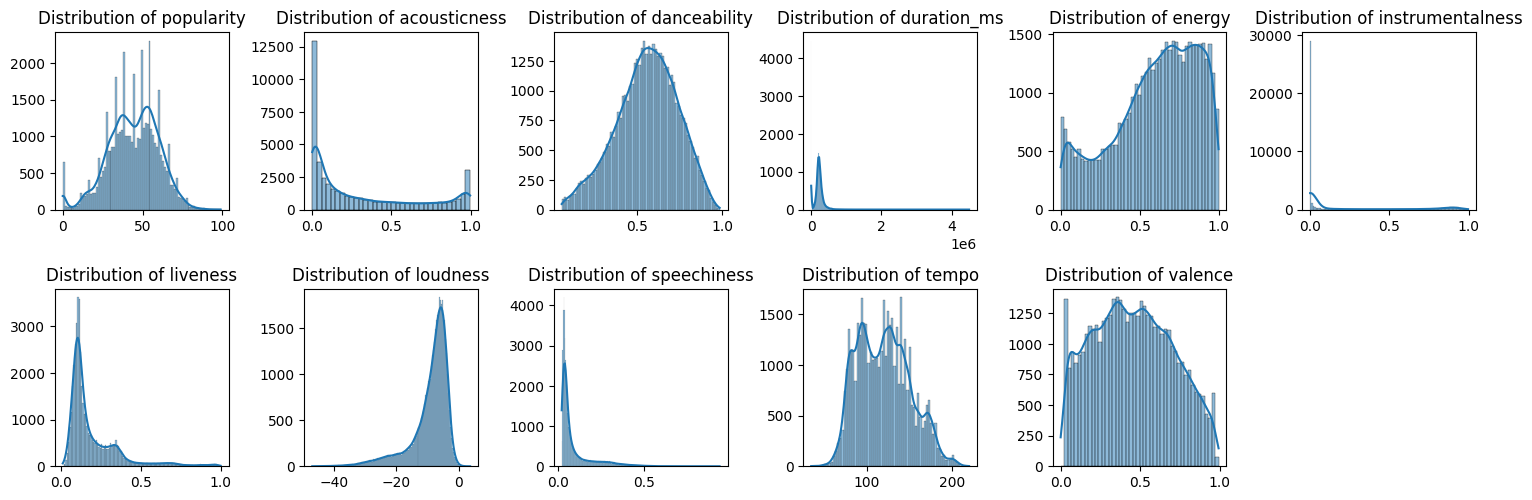

In [6]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(4, 6, i + 1) #adjusts subplot grid based on number of features
    sb.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

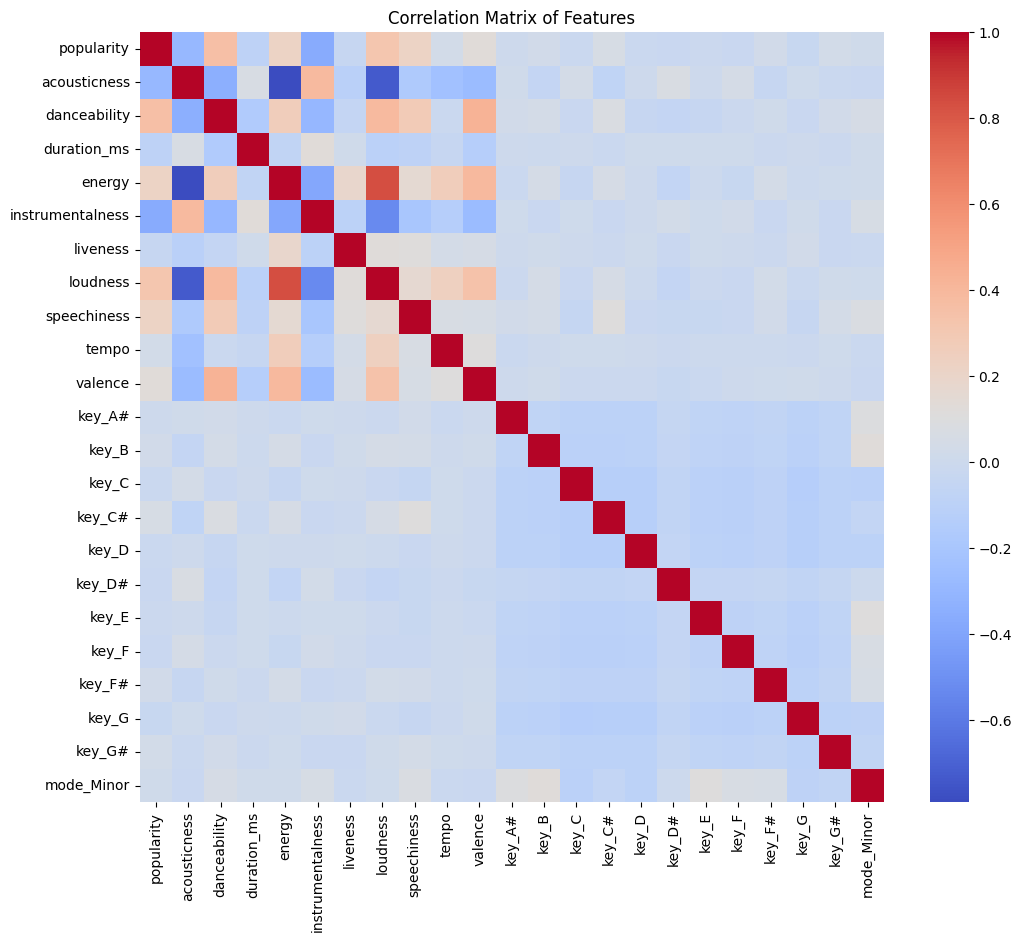

In [7]:
plt.figure(figsize=(12, 10))
sb.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm', fmt=".2f") # annot=False for too many features
plt.title('Correlation Matrix of Features')
plt.show()

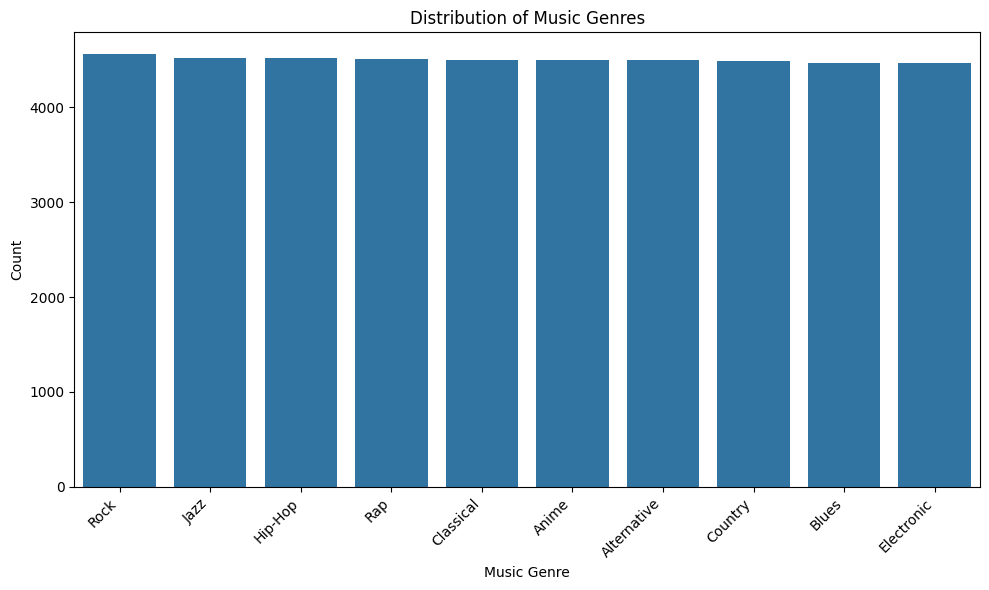

In [8]:
plt.figure(figsize=(10, 6))
sb.countplot(data=df, x='music_genre', order=df['music_genre'].value_counts().index)
plt.title('Distribution of Music Genres')
plt.xlabel('Music Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
def evaluate_classification_model(model_name, y_true_encoded, y_pred_encoded, y_prob=None):
    print(f"\n{model_name} eval")
    print("-----------------------------------------\n")

    # calc accuracy
    accuracy = accuracy_score(y_true_encoded, y_pred_encoded)
    print(f"accuracy: {accuracy:.4f}")

    # calc f1 score, use weighetd cause its a common mlticlass adaptation, also zero div just incase theres not a pred
    f1 = f1_score(y_true_encoded, y_pred_encoded, average='weighted', zero_division=0)
    print(f"f1 score: {f1:.4f}")

    #calc precision
    precision = precision_score(y_true_encoded, y_pred_encoded, average='weighted', zero_division=0)
    print(f"precision: {precision:.4f}")

    #calculate recall
    recall = recall_score(y_true_encoded, y_pred_encoded, average='weighted', zero_division=0)
    print(f"recall: {recall:.4f}")

    #calc roc auc if probabilities are provided
    if y_prob is not None:
        # ensure y_true is binarized for roc_auc_score in multiclass
        y_true_binarized = label_binarize(y_true_encoded, classes=range(num_classes))
        roc_auc = roc_auc_score(y_true_binarized, y_prob, average='weighted', multi_class='ovr')
        print(f"roc auc score: {roc_auc:.4f}")

    #calculate confusion matrix
    conf_matrix = confusion_matrix(y_true_encoded, y_pred_encoded)
    print("confusion matrix:\n", conf_matrix)
    genre_labels = label_encoder.classes_
    sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)  # 'annot=True' shows numbers
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.show()


SGD Train eval
-----------------------------------------

accuracy: 0.4919
f1 score: 0.4863
precision: 0.4938
recall: 0.4919
roc auc score: 0.8836
confusion matrix:
 [[ 757   27  110   18  745  262  274  236  128  589]
 [  87 1850  217  265  301  257    3  155    2   11]
 [ 125  507 1156   62  552  189    5  363    8  162]
 [  66  218   61 2363   64   87    0  275    0   16]
 [ 161   80  320   11 1816   75   68  123   23  463]
 [ 171  255  164   44  209 1846   86  243   29   79]
 [ 155    0   33    2  226  111 1468   81  880  208]
 [  72  157  351  233  324  473  112 1300   28  115]
 [ 208    0   18    0  206   60 1229   76  955  401]
 [ 285    7   55   14  532   44   62  110   92 1992]]


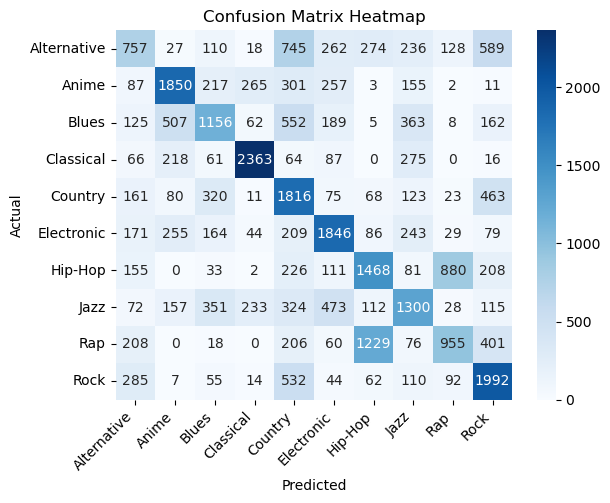


SGD Test eval
-----------------------------------------

accuracy: 0.4880
f1 score: 0.4817
precision: 0.4896
recall: 0.4880
roc auc score: 0.8813
confusion matrix:
 [[ 321   18   61    9  324   97  105  100   51  263]
 [  35  757   90  126  134  129    2   68    1    7]
 [  53  223  490   21  245   72    7  161    1   68]
 [  23   87   26 1027   28   44    0  108    0    7]
 [  57   35  138    6  802   44   33   52    9  170]
 [  70  103   68   16   82  781   52  113   17   38]
 [  66    0   11    1   91   52  621   46  375   93]
 [  24   65  132   97  142  226   40  569   13   48]
 [  89    0    7    1  100   25  557   28  388  156]
 [ 133    4   24    6  217   28   33   53   35  835]]


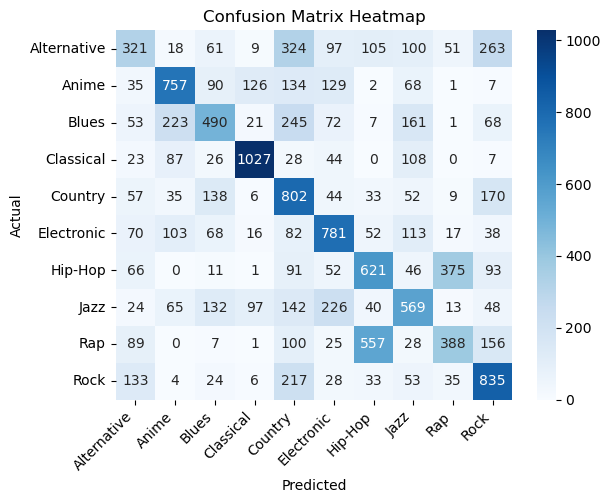

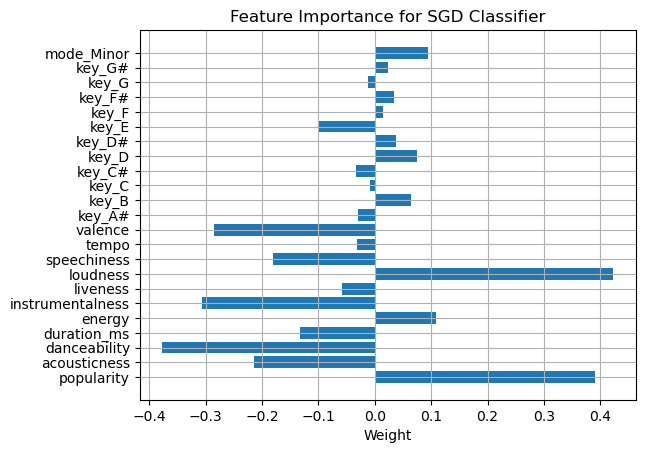

In [10]:
# model 1: sgdclassifier
sgd_model = SGDClassifier(loss='log_loss',penalty='l2', alpha=0.0001, max_iter=1000, eta0=0.01, learning_rate='constant', tol=1e-3)

# pred labels and probabilities
sgd_model.fit(X_train_scaled, y_train)

y_pred_sgd = sgd_model.predict(X_test_scaled)

y_prob_sgd = sgd_model.predict_proba(X_test_scaled)

y_pred_train_sgd = sgd_model.predict(X_train_scaled)

y_prob_train_sgd = sgd_model.predict_proba(X_train_scaled)

# evaluate sgdclassifier
evaluate_classification_model("SGD Train", y_train, y_pred_train_sgd, y_prob_train_sgd)
evaluate_classification_model("SGD Test", y_test, y_pred_sgd, y_prob_sgd)

sgd_best_features = sgd_model.coef_[0]
plt.barh(feature_names, sgd_best_features)
plt.xlabel("Weight")
plt.title("Feature Importance for SGD Classifier")
plt.grid(True)
plt.show()


Random Forest Train eval
-----------------------------------------

accuracy: 0.5792
f1 score: 0.5641
precision: 0.5886
recall: 0.5792
roc auc score: 0.9239
confusion matrix:
 [[ 620   65   63    6  552  310  347  195  106  882]
 [  39 2257  164  329  135  145    2   48    4   25]
 [  49  347 1467   59  370  304   20  307    8  198]
 [  52   88   44 2713   29  108    1   98    0   17]
 [  58   52  117    5 1828   41   87  119   31  802]
 [  77  194  159   17  121 2048   62  270   26  152]
 [  22    2    6    0   48   31 2112   19  667  257]
 [  32   48  268  257  285  477   80 1539   12  167]
 [  40    2    4    0   22   15 1529   18 1006  517]
 [ 106    8    8   13   64   25  120   62  124 2663]]


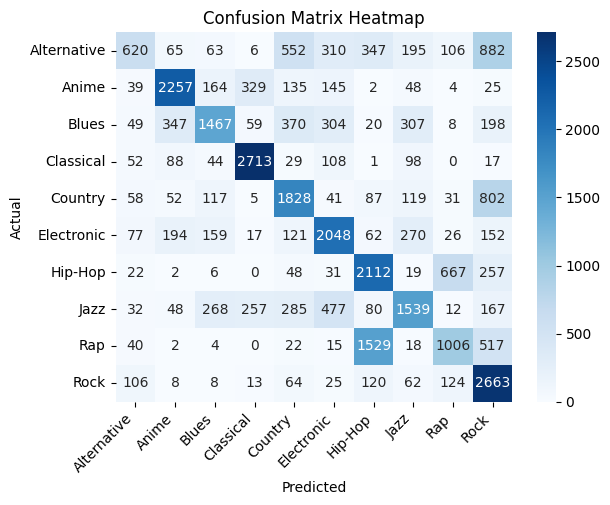


Random Forest Test eval
-----------------------------------------

accuracy: 0.5458
f1 score: 0.5279
precision: 0.5507
recall: 0.5458
roc auc score: 0.9140
confusion matrix:
 [[ 229   34   38    2  238  117  136   97   39  419]
 [  12  906   82  170   52   75    0   34    1   17]
 [  38  148  564   31  181  127    8  158    2   84]
 [  20   42   28 1154   15   34    0   46    0   11]
 [  25   34   46    7  792   26   35   56   15  310]
 [  31   95   59   13   65  805   39  155   14   64]
 [   7    3    1    0   12   19  845   11  329  129]
 [   5   16  118  151  121  220   39  596    9   81]
 [  17    1    1    0    5   15  726    5  360  221]
 [  48    6    2    3   21   14   60   31   62 1121]]


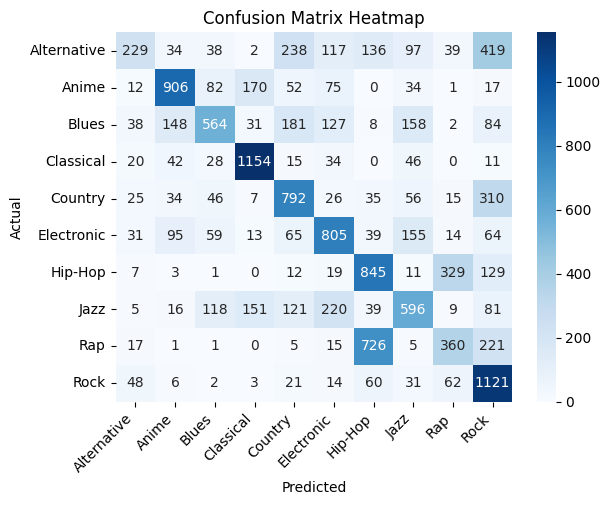

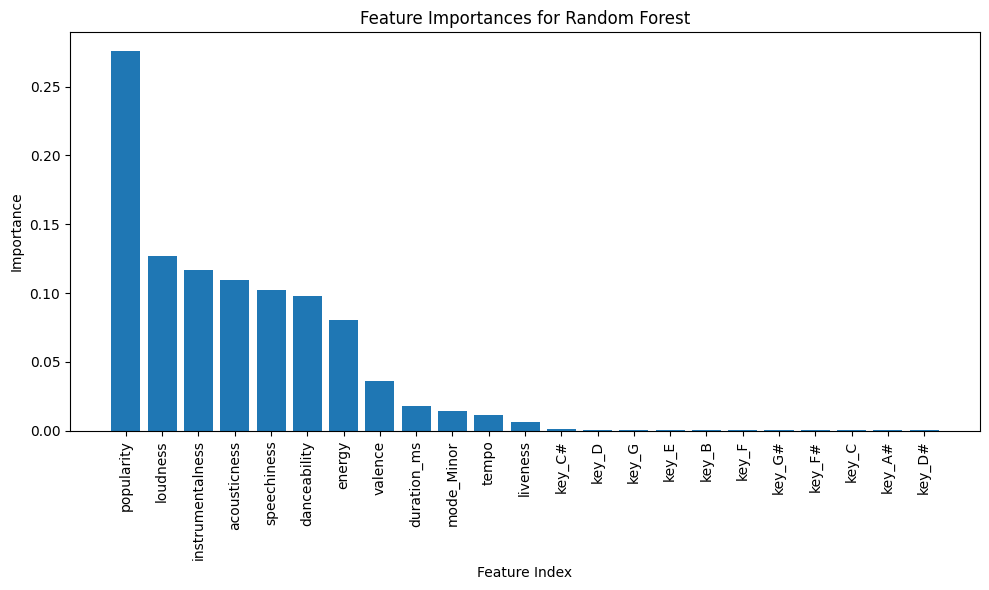

In [20]:
#model 2: random forest classififer
#n_jobs=-1 to use all available cores for faster training.
rf_model = RandomForestClassifier( n_estimators=50, max_depth=7, random_state=42,n_jobs=-1,
                                  )
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)

y_pred_train_sgd = rf_model.predict(X_train_scaled)
y_prob_train_sgd = rf_model.predict_proba(X_train_scaled)

evaluate_classification_model("Random Forest Train" , y_train, y_pred_train_sgd, y_prob_train_sgd)
evaluate_classification_model("Random Forest Test", y_test, y_pred_rf, y_prob_rf)

rf_best_features = rf_model.feature_importances_
rf_best_feat_indices = np.argsort(rf_best_features)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances for Random Forest")
plt.bar(range(X_train_scaled.shape[1]), rf_best_features[rf_best_feat_indices])
plt.xticks(range(X_train_scaled.shape[1]), np.array(feature_names)[rf_best_feat_indices], rotation=90)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [12]:
# model 3: nn with gridsearch 

def NNmodel_struct(learning_rate=0.001, dropout_rate=0.2, reg_lambda_l2=0.01, neurons_layer1=128, neurons_layer2=64):
    model = Sequential()

    # input layer

    # X_train_scaled.shape[1] is the # of features after scaling and onehot encoding
    model.add(Dense(neurons_layer1, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(reg_lambda_l2)))
    model.add(Dropout(dropout_rate))

    # using fixed 2 hidden layers
    model.add(Dense(neurons_layer2, activation='relu', kernel_regularizer=l2(reg_lambda_l2)))
    model.add(Dropout(dropout_rate))

    # output layer for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)

    # use cross entropy cuz its the best for this architecutre
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# define par grid for manual search
param_grid_nn_manual = {
    'neurons_layer1': [64, 128],
    'neurons_layer2': [32, 64],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.0005],
    'reg_lambda_l2': [0.01, 0.001],
    'batch_size': [32, 64],
    'epochs': [25, 50]
}

# store results from manual grid search
results_nn_manual = []
best_nn_accuracy = 0.0
best_nn_params = {}
best_nn_model_manual = None

# for kfold cross validation in the manual loop
n_folds = 2
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

print("starting gridsearch for nn")

# go thru all combos of parameters
# itertools.product to create all combinations causde the gridsearch lib wasnt working
import itertools
keys, values = zip(*param_grid_nn_manual.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

for i, params in enumerate(param_combinations):
    print(f"testing combo {i+1}/{len(param_combinations)}: {params}")
    fold_accuracies = []

    # k fold cross-validation loop
    for fold, (train_index, val_index) in enumerate(kf.split(X_train_scaled, y_train_nn)):
        print(f"  fold {fold+1}/{n_folds}")
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train_nn[train_index], y_train_nn[val_index] # use one-hot encoded targets

        # create and compile the model with current params
        # extract specific params for model creation and others for fit
        model_params = {k: params[k] for k in ['neurons_layer1', 'neurons_layer2', 'dropout_rate', 'learning_rate', 'reg_lambda_l2']}
        current_model = NNmodel_struct(**model_params)

        # train the model
        current_model.fit(X_train_fold, y_train_fold, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0) 

        # eval on the validation fold
        _, accuracy_val = current_model.evaluate(X_val_fold, y_val_fold, verbose=0)
        fold_accuracies.append(accuracy_val)

    # average acc across folds
    avg_fold_accuracy = np.mean(fold_accuracies)
    print(f"  avg validation accuracy: {avg_fold_accuracy:.4f}")
    results_nn_manual.append({'params': params, 'accuracy': avg_fold_accuracy})

    # update best model if current is better
    if avg_fold_accuracy > best_nn_accuracy:
        best_nn_accuracy = avg_fold_accuracy
        best_nn_params = params

print(f"\ngridsearch complete.")
print(f"best nn validation accuracy: {best_nn_accuracy:.4f}")
print(f"best nn params: {best_nn_params}")


starting gridsearch for nn
testing combo 1/128: {'neurons_layer1': 64, 'neurons_layer2': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'reg_lambda_l2': 0.01, 'batch_size': 32, 'epochs': 25}
  fold 1/2


C:\Users\aaron\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  fold 2/2
  avg validation accuracy: 0.5382
testing combo 2/128: {'neurons_layer1': 64, 'neurons_layer2': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'reg_lambda_l2': 0.01, 'batch_size': 32, 'epochs': 50}
  fold 1/2
  fold 2/2
  avg validation accuracy: 0.5479
testing combo 3/128: {'neurons_layer1': 64, 'neurons_layer2': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'reg_lambda_l2': 0.01, 'batch_size': 64, 'epochs': 25}
  fold 1/2
  fold 2/2
  avg validation accuracy: 0.5348
testing combo 4/128: {'neurons_layer1': 64, 'neurons_layer2': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'reg_lambda_l2': 0.01, 'batch_size': 64, 'epochs': 50}
  fold 1/2
  fold 2/2
  avg validation accuracy: 0.5492
testing combo 5/128: {'neurons_layer1': 64, 'neurons_layer2': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'reg_lambda_l2': 0.001, 'batch_size': 32, 'epochs': 25}
  fold 1/2
  fold 2/2
  avg validation accuracy: 0.5594
testing combo 6/128: {'neurons_layer1': 64, 'neurons_layer2': 32, 

training the best nn model
Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3418 - loss: 1.9152 - val_accuracy: 0.5137 - val_loss: 1.3920
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4987 - loss: 1.4397 - val_accuracy: 0.5312 - val_loss: 1.3322
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5174 - loss: 1.3674 - val_accuracy: 0.5423 - val_loss: 1.3016
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5312 - loss: 1.3207 - val_accuracy: 0.5455 - val_loss: 1.2698
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5366 - loss: 1.2987 - val_accuracy: 0.5494 - val_loss: 1.2560
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5400 - loss: 1.2738 - val_accuracy: 0.5521 - val_loss: 1.2510
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5421 - loss: 1.2663 - val_accuracy: 0.5572 - val_loss: 1.2310
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5482 - loss

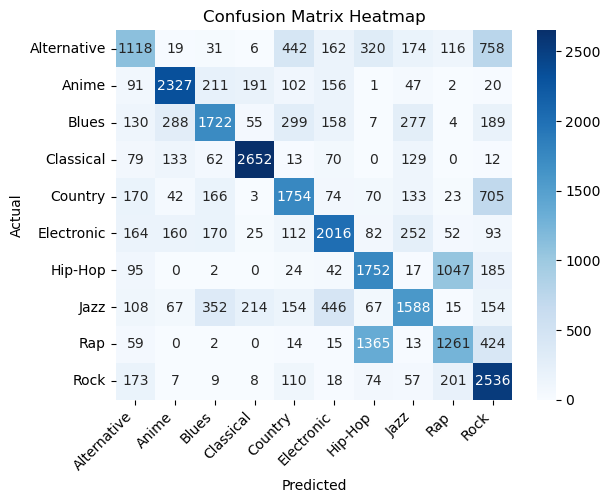


Neural Network Test eval
-----------------------------------------

accuracy: 0.5724
f1 score: 0.5672
precision: 0.5739
recall: 0.5724
roc auc score: 0.9269
confusion matrix:
 [[ 417   11   22    7  218   61  119   78   50  366]
 [  42  972   83  104   36   75    0   24    2   11]
 [  60  124  672   19  159   74    1  153    3   76]
 [  32   63   34 1125    8   26    0   54    0    8]
 [  82   26   79    1  722   53   21   73   13  276]
 [  83   73   64   18   59  824   32  116   28   43]
 [  45    0    2    0    9   12  746    8  437   97]
 [  37   29  142  102   79  192   40  671    3   61]
 [  44    0    0    0    7   10  599    7  517  167]
 [  83    5    5    3   46   11   39   32   79 1065]]


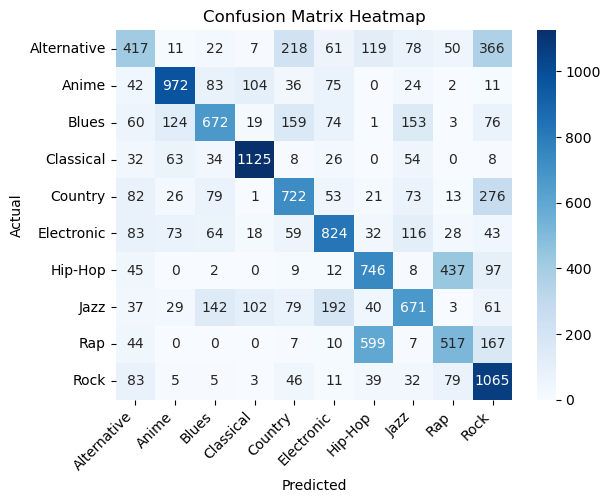

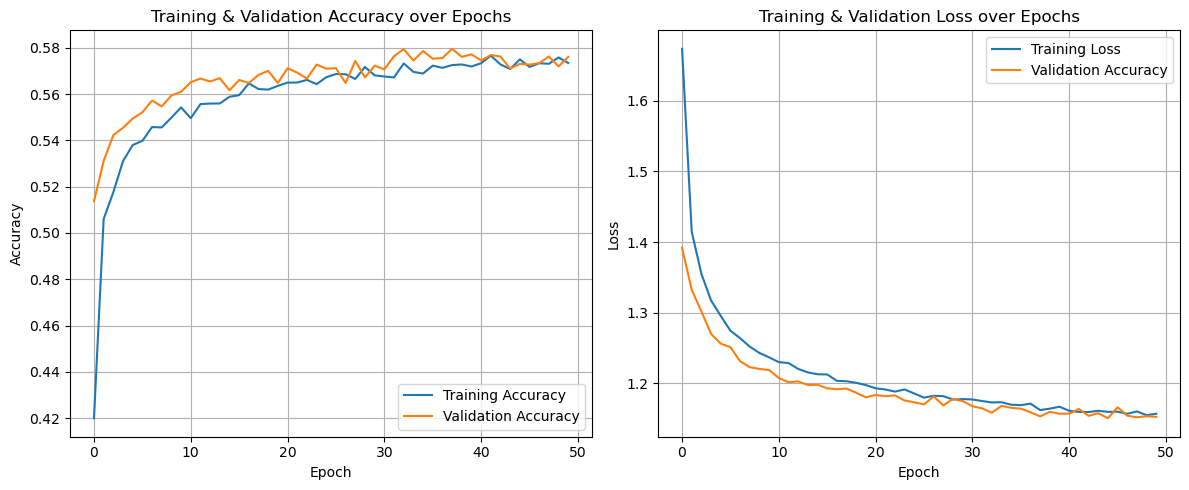

In [13]:
print("training the best nn model")
final_model_params = {k: best_nn_params[k] for k in ['neurons_layer1', 'neurons_layer2', 'dropout_rate', 'learning_rate', 'reg_lambda_l2']}
best_nn_model_manual = NNmodel_struct(**final_model_params)

# use one hot
history = best_nn_model_manual.fit(X_train_scaled, y_train_nn, epochs=best_nn_params['epochs'], batch_size=best_nn_params['batch_size'], verbose=1, validation_split = 0.2) # show progress for final model

# pred labels and probabilities with the best nn model
y_prob_nn_manual = best_nn_model_manual.predict(X_test_scaled)
#convert probabilities to class label
y_pred_nn_manual_encoded = np.argmax(y_prob_nn_manual, axis=1)

y_prob_nn_manual_Train = best_nn_model_manual.predict(X_train_scaled)
y_pred_nn_manual_encoded_Train = np.argmax(y_prob_nn_manual_Train, axis=1)

#evaluate the best nn model
evaluate_classification_model("Neural Network Train", y_train, y_pred_nn_manual_encoded_Train, y_prob_nn_manual_Train)
evaluate_classification_model("Neural Network Test", y_test, y_pred_nn_manual_encoded, y_prob_nn_manual)

# Plot the accuracy over the epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Accuracy')
plt.title('Training & Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [14]:
import joblib

# save the best nn
best_nn_model_manual.save('best_nn_model.keras')

# save Random Forest 
joblib.dump(rf_model, 'rf_model.pkl')

joblib.dump(sgd_model, 'sgd_model.pkl')

# save preprocessing objects (gonna use it on backend)
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# save the actual test set as csv for flask
test_set_data = df.iloc[X_test.index].copy()
test_set_data.to_csv('test_set.csv', index=False)

# save model info and feature names
model_info = {
    'feature_names': feature_names,
    'num_classes': num_classes,
    'class_names': label_encoder.classes_.tolist(),
    'best_nn_params': best_nn_params,
    'input_dim': input_dim_nn
}
joblib.dump(model_info, 'model_info.pkl')

['model_info.pkl']